# Exploration

**Goal**
> Changes in google results across time

## Roadmap

1. Load and merge data
2. Impute results count for a daily count
3. Visualize
    1. Line plot with plotly

### Load and merge data

In [14]:
import yaml
# ~--- SETTINGS ---
with open('../settings.yml') as file:
    settings = yaml.full_load(file)
    PROJECT_DIR = settings['project']['root_dir']
    RAW_DATA_DIR = settings['project']['raw_data_dir']
    FINAL_DATA_DIR = settings['project']['final_data_dir']
    FILENAME = settings['project']['export_filename']
# ~--------------

from glob import glob
import pandas as pd
import os

# -- LOAD
def load_data(project_dir, raw_data_dir, filename_contains='*csv'):
    """ Load all results count data, merge into a single dataframe """
    data_files = glob(os.path.join(project_dir, raw_data_dir, filename_contains))
    df = pd.concat([pd.read_csv(df) for df in data_files]).reset_index(drop=True)
    df.query_timestamp = pd.to_datetime(df.query_timestamp) 
    
    # assert columns
    expected_columns = ['keyword', 'results_count', 'search_url', 'query_timestamp']
    assert_columns = list(set(df.columns).difference(set(expected_columns)))
    assert len(assert_columns) == 0,\
        f"Expected columns {expected_columns}.\nFound {assert_columns} instead."
    # assert at least 1 datetime column
    assert (df.dtypes == 'datetime64[ns]').any(), "Column type 'Datetime64[ns]' not found in dataframe "
    return df

# -- FEATURE ENGINEERING
def impute_results_count(df):
    """ Impute timestamp to daily observations, interpolate with polynomial """
    
    # categorical columns to group on (keyword and search_url)
    groupby_columns = df.select_dtypes('object').columns.to_list()

    # assert expected grouping columns
    expect_object_columns = ['search_url', 'keyword']
    assert set(groupby_columns) == set(expect_object_columns), \
        f"Columns {groupby_columns} not in {expect_object_columns} "

    kw_list, url_list = df.keyword.unique(), df.search_url.unique()
    df_list = []
    for kw, url in dict(zip(kw_list, url_list)).items():
        df_temp = df.set_index('query_timestamp')\
                .query(f"keyword=='{kw}'")\
                .resample('D').mean()\
                .results_count.interpolate(method='polynomial', order=5)\
                .reset_index() 
        df_temp['keyword'],df_temp['search_url']  = kw, url
        df_list.append(df_temp)
        
    df = pd.concat(df_list)
    
    return df

# df = (load_data(project_dir=PROJECT_DIR, raw_data_dir=RAW_DATA_DIR)
#             .pipe(impute_results_count)).reset_index(drop=True)

df = load_data(PROJECT_DIR, RAW_DATA_DIR)

In [24]:
kw = 'greenwashing'
df.set_index('query_timestamp')\
                .query(f"keyword=='{kw}'")\
                .resample('D').mean()\
                .results_count.interpolate(method='polynomial', order=5)
# \
#                 .reset_index() 

ValueError: The number of derivatives at boundaries does not match: expected 4, got 0+0

In [15]:
impute_results_count(df)

ESG https://www.google.com/search?q=ESG
sustainable finance https://www.google.com/search?q=sustainable+finance
responsible investment https://www.google.com/search?q=responsible+investment
impact investing https://www.google.com/search?q=impact+investing
green finance https://www.google.com/search?q=green+finance
sustainable investment https://www.google.com/search?q=sustainable+investment
socially responsible investment https://www.google.com/search?q=socially+responsible+investment
greenwashing https://www.google.com/search?q=greenwashing


ValueError: The number of derivatives at boundaries does not match: expected 4, got 0+0

In [12]:
kw_list, url_list = df.keyword.unique(), df.search_url.unique()
kw = kw_list[0]
df_temp = df.set_index('query_timestamp')\
        .query(f"keyword=='{kw}'")\
        .resample('D').mean()\
        .results_count.interpolate(method='polynomial', order=5)\
        .reset_index() 

### Feature engineering

In [75]:
# calculate day-to-day change  
df['result_count_absolute_change'] = df.groupby('keyword').results_count.diff() 
df['result_count_relative_change'] = df.result_count_absolute_change/df.results_count*100
# df.loc[df.result_count_change == df.result_count_change.max()]

### Stats

In [77]:
max_absolute_change = df.loc[df.result_count_absolute_change == df.result_count_absolute_change.max()]
max_relative_change = df.loc[df.result_count_relative_change == df.result_count_relative_change.max()]
# absolute_change_all_time = 
# relative_change_all_time = 

In [155]:
# TODO: calc. start/enddate with groupby('keyword') to allow for keywords that are later added
start_date, end_date = df.query_timestamp.min(), df.query_timestamp.max() 

from datetime import date
start_end_period_length = (end_date-start_date).days

filter_start_enddate = (df.query_timestamp == start_date) | (df.query_timestamp == end_date)
df['overall_absolute_change'] = df.loc[filter_start_enddate].groupby('keyword').results_count.diff() 
# df['overall_relative_change'] = df.overall_absolute_change/df.#TODO: divide by results_count at start_date
# 
df_overall_change = df.dropna().loc[:,['keyword', 'results_count', 'query_timestamp','overall_absolute_change']].reset_index(drop=True)
df_overall_change['query_start_date'] = df.groupby('keyword').query_timestamp.min().reset_index(drop=True)
df_overall_change['query_end_date'] = df.groupby('keyword').query_timestamp.max().reset_index(drop=True)
df_overall_change['results_count_start'] = df.loc[df.query_timestamp == df_overall_change.query_start_date.iloc[0]].results_count.reset_index(drop=True)
df_overall_change['overall_relative_change'] = ((df_overall_change.results_count / df_overall_change.results_count_start)-1)*100

df_overall_change


,keyword,results_count,query_timestamp,overall_absolute_change,query_start_date,query_end_date,results_count_start,overall_relative_change
0,ESG,8.020000e+07,2021-03-23,1500000.0,2021-03-07,2021-03-23,7.870000e+07,1.905972
1,sustainable finance,4.690000e+08,2021-03-23,-46000000.0,2021-03-07,2021-03-23,5.150000e+08,-8.932039
2,responsible investment,1.070000e+09,2021-03-23,80000000.0,2021-03-07,2021-03-23,9.900000e+08,8.080808
3,impact investing,2.890000e+08,2021-03-23,28000000.0,2021-03-07,2021-03-23,2.610000e+08,10.727969
4,green finance,1.510000e+09,2021-03-23,-190000000.0,2021-03-07,2021-03-23,1.700000e+09,-11.176471
5,sustainable investment,4.440000e+08,2021-03-23,-55000000.0,2021-03-07,2021-03-23,4.990000e+08,-11.022044
6,socially responsible investment,5.910000e+07,2021-03-23,-1400000.0,2021-03-07,2021-03-23,6.050000e+07,-2.314050


### Plot

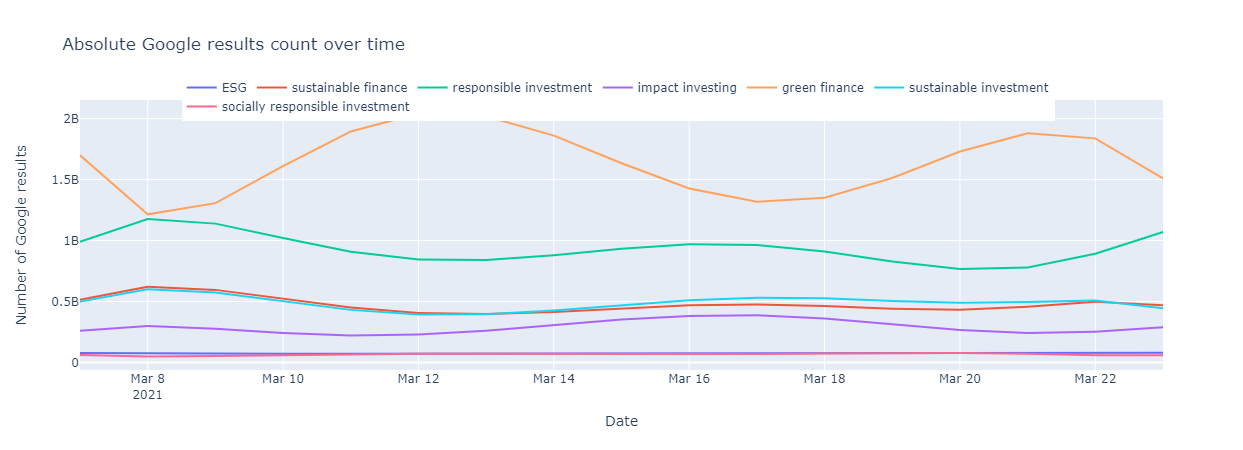

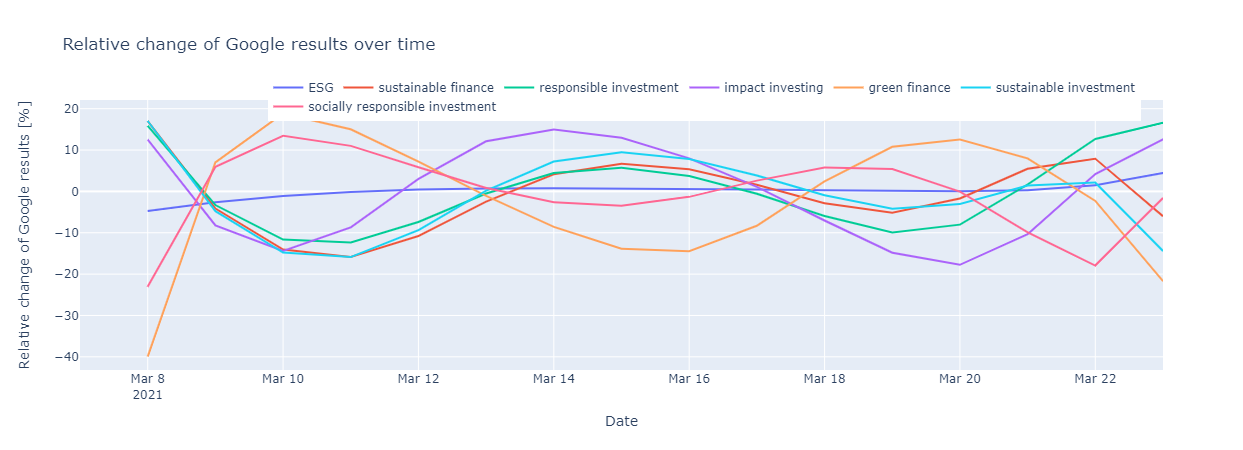

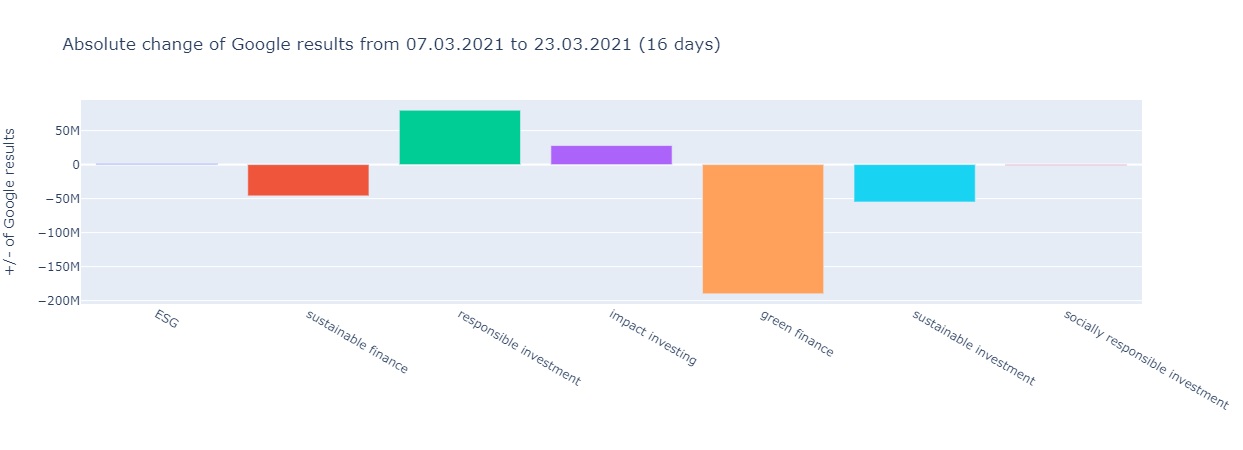

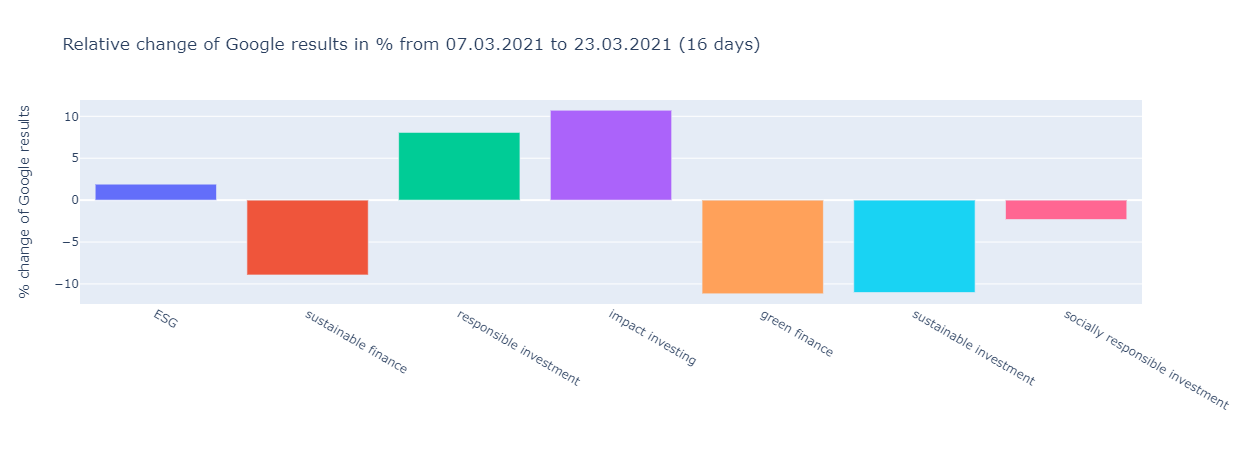

In [159]:
import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py

fig = px.line(df, x="query_timestamp", y="results_count", color="keyword", 
              title='Absolute Google results count over time', 
             labels={
                     "query_timestamp": "Date",
                     "results_count": "Number of Google results",
                     "keyword": ""
                 },)
# update legend
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=1.1,
    xanchor="right", 
    x=0.9
))
fig.show()

fig = px.line(df, x="query_timestamp", y="result_count_relative_change", color="keyword", 
             title='Relative change of Google results over time', 
            labels={
                     "query_timestamp": "Date",
                     "result_count_relative_change": "Relative change of Google results [%]",
                     "keyword": ""
                 },)
# update legend
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=1.1,
    xanchor="right", 
    x=.98
))
fig.show()

fig_abs_overall_change = px.bar(df_overall_change, x="keyword", y="overall_absolute_change", color="keyword", 
             title='Absolute change of Google results from {start} to {end} ({days} days)'.format(start=start_date.strftime('%d.%m.%Y'), 
                                                                                             end=end_date.strftime('%d.%m.%Y'), 
                                                                                            days=start_end_period_length), 
            labels={
                     "overall_absolute_change": "+/- of Google results",
                     "keyword": ""
                 },)
fig_abs_overall_change.update_layout(showlegend=False)
fig_abs_overall_change.show()

fig_rel_overall_change = px.bar(df_overall_change, x="keyword", y="overall_relative_change", color="keyword", 
             title='Relative change of Google results in % from {start} to {end} ({days} days)'.format(start=start_date.strftime('%d.%m.%Y'), 
                                                                                                  end=end_date.strftime('%d.%m.%Y'), 
                                                                                                 days=start_end_period_length), 
            labels={
                     "overall_relative_change": "% change of Google results",
                     "keyword": ""
                 },)
fig_rel_overall_change.update_layout(showlegend=False)
fig_rel_overall_change.show()

#### Deploy

In [161]:
py.plot(fig_abs_overall_change, filename=FILENAME+"_change_overall_absolute", auto_open=True)

py.plot(fig_rel_overall_change, filename=FILENAME+"_change_overall_relative", auto_open=True)

'https://plotly.com/~philippschmalen/97/'